In [1]:
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import ngboost as ng
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm

from sklearn.metrics import mean_squared_error

from models.flow import build_model
from tfboost.flow import ContinuousNormalizingFlow
from tfboost.tree.engboost import EmbeddableNGBoost, EmbeddableNGBoostDecisionPath
from tfboost.tfboost import TreeFlowBoost

In [2]:
def _generate_data(n=100, std=0.1):
    eps = std * np.random.randn(n)
    x = np.random.rand(n) * 4*np.pi - 2*np.pi
    y = np.sin(x) + eps
    return x, y


def generate_data(n=100, std=0.1):
    x1, y1 = _generate_data(n=n, std=std)
    x2, y2 = _generate_data(n=n, std=std)
    y2 = -y2
    return (
        np.concatenate([x1, x2]),
        np.concatenate([y1, y2])
    )

In [3]:
x, y = generate_data(n=300, std=0.1)

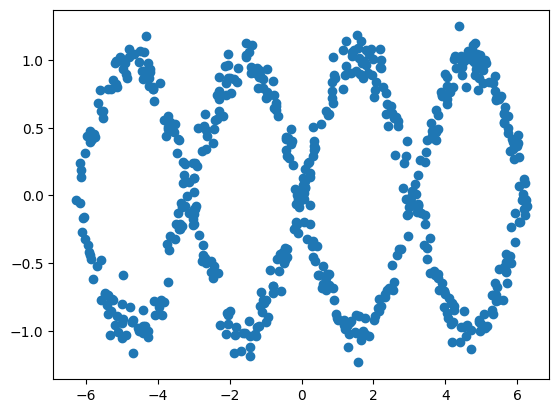

In [4]:
plt.scatter(x, y)
plt.show()

In [5]:
X_train, y_train = x.reshape(-1, 1), y
X_test, y_test = generate_data(100)
X_test = X_test.reshape(-1, 1)

In [6]:
flow = ContinuousNormalizingFlow(build_model(
    input_dim=1,
    hidden_dims=(80,),
    context_dim=40,
    conditional=True,
))

tree = EmbeddableNGBoost()

tfb = TreeFlowBoost(flow_model=flow, tree_model = tree, embedding_size=40)

In [7]:
tfb.fit(X_train, y_train, n_epochs=200)

[iter 0] loss=1.0827 val_loss=0.0000 scale=2.0000 norm=1.5307
[iter 100] loss=0.9365 val_loss=0.0000 scale=2.0000 norm=1.3927
[iter 200] loss=0.8492 val_loss=0.0000 scale=2.0000 norm=1.3194
[iter 300] loss=0.7689 val_loss=0.0000 scale=2.0000 norm=1.2546
[iter 400] loss=0.6990 val_loss=0.0000 scale=2.0000 norm=1.1979


-0.7582190632820129: 100%|██████████| 200/200 [00:42<00:00,  4.72it/s]  


TreeFlowBoost(embedding_size=40,
              flow_model=<tfboost.flow.ContinuousNormalizingFlow object at 0x7f26754e4190>,
              tree_model=<tfboost.tree.engboost.EmbeddableNGBoost object at 0x7f26754e4090>)

# Samples

In [8]:
samples = tfb.sample(X_train, num_samples=50)

In [9]:
y_hat = tfb.predict(X_train, num_samples=50)

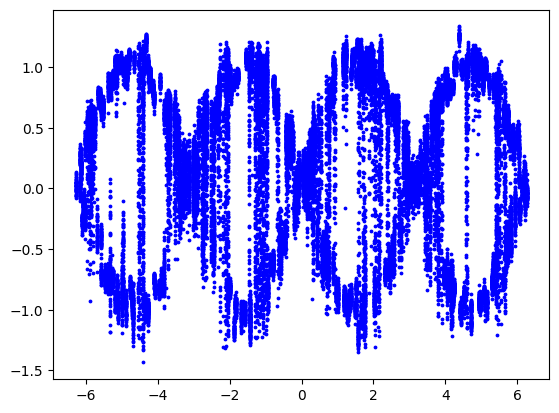

In [10]:
for i in range(samples.shape[1]):
    plt.scatter(X_train, samples[:, i], s=3, c='b')

    
# plt.scatter(X_train, y_hat, s=3, c='r')
plt.show()

# Embeddings

In [11]:
e = tfb.tree_model.embed(X_train)

In [12]:
e.shape

(600, 7708)

In [13]:
embeddings = tfb.embed(X_train)

In [14]:
embeddings.shape

(600, 40)

In [15]:
import umap

In [16]:
embeddings_2d = umap.UMAP().fit_transform(embeddings)

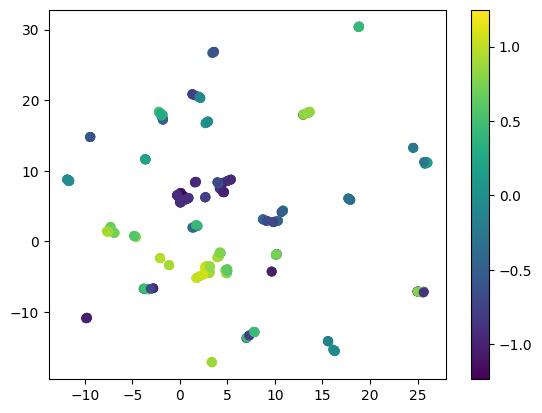

In [17]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_train)
plt.colorbar()
plt.show()

# Log prob

In [18]:
size = 300

x_new, y_new = np.meshgrid(
    np.linspace(-2*np.pi - 1.0, 2*np.pi + 1.0, size),
    np.linspace(-1.1, 1.1, size)
)

x_new = x_new.reshape(-1, 1)
y_new = y_new.reshape(-1, 1)

In [19]:
logpx = tfb.log_prob(x_new, y_new)

In [20]:
logpx

array([[-84.37297 ],
       [-84.72673 ],
       [-84.44248 ],
       ...,
       [-68.620575],
       [-68.32639 ],
       [-68.36783 ]], dtype=float32)

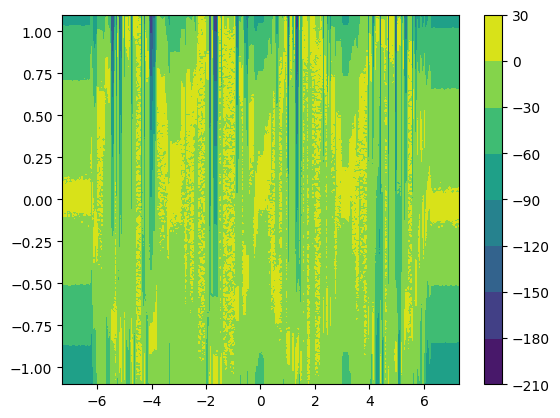

In [21]:
plt.contourf(
    x_new.reshape(size, size),
    y_new.reshape(size, size),
    logpx.reshape(size, size)
)
plt.colorbar()
plt.show()